# CSE 251B Kaggle  Competition - Autobots roll out!

### Imports

In [4]:
import os

# Data processing & linear algebra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

### Data Loading

In [2]:
# Load in data files
train_file = np.load("data/train.npz")
test_file = np.load("data/test_input.npz")

train_data = train_file["data"]
test_data = test_file["data"]

print("(scenes, trajectories, time steps, dimensions)")
print(f"train data shape: {train_data.shape}")
print(f"test data shape:  {test_data.shape}")

(scenes, trajectories, time steps, dimensions)
train data shape: (10000, 50, 110, 6)
test data shape:  (2100, 50, 50, 6)


## Dataset Description

This notebook is part of the UCSD CSE 251B trajectory forecasting competition. The task involves predicting the future (x, y) positions of an ego vehicle in a multi-agent traffic scene using motion data over time.

---

### Dataset Structure

We are provided with two main `.npz` files:

* **`train.npz`** → shape: `(10000, 50, 110, 6)`
* **`test_input.npz`** → shape: `(2100, 50, 50, 6)`

Each data point is a 4D tensor:

```
(scenes, agents, timesteps, features)
```

#### Dimensions Explained

| Dimension | Meaning                                     |
| --------- | ------------------------------------------- |
| Scenes    | One driving scenario (10k train, 2.1k test) |
| Agents    | 50 agents (vehicles, pedestrians, etc.)     |
| Timesteps | 110 total in train (50 input, 60 output)    |
| Features  | 6 features per agent per timestep           |

---

### Features Breakdown

Each timestep contains 6 features:

| Index | Feature       | Description                                   |
| ----- | ------------- | --------------------------------------------- |
| 0     | `x`           | x-coordinate of agent position                |
| 1     | `y`           | y-coordinate of agent position                |
| 2     | `vx`          | velocity in x-direction                       |
| 3     | `vy`          | velocity in y-direction                       |
| 4     | `θ` (theta)   | heading angle in radians                      |
| 5     | `object_type` | Integer representing object class (see below) |

#### Object Class Encoding

```
['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus',
 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']
```

> Many agents may be **missing full trajectories** or not present at all. In such cases, rows are **zero-padded**.

---

### Learning Task

We are asked to predict the **future 60 (x, y) positions** of the **ego agent** (agent index `0`) in each test scene.

* **Input (X):**

  * Shape: `(scenes, 50 agents, 50 timesteps, 6 features)`
  * Available for both `train_data` and `test_data`

* **Target (Y - train only):**

  * Shape: `(scenes, 1 agent, 60 timesteps, 2 coordinates)`
  * Only `(x, y)` positions for **ego vehicle** over future 60 steps

* **Submission format:**

  * A `.csv` file with shape `(2100 × 60, 2)` = `(126000, 2)`

---

### Evaluation Metric

 **Mean Squared Error (MSE)** between predicted and ground truth future positions of the ego vehicle.

---

### Summary

* **Train scenes:** 10,000
* **Test scenes:** 2,100
* **Agents per scene:** 50
* **Timesteps:** 110 (train), 50 (test)
* **Features per timestep:** `x, y, vx, vy, θ, object_type`
* **Objective:** Predict 60-step future `(x, y)` for ego agent (index 0)

> Understanding and leveraging spatio-temporal patterns in agent motion is key to high-performing models.


In [3]:
def display_gif(data_matrix, step=2):
    max_agents = data_matrix.shape[0]
    cmap = plt.cm.get_cmap('viridis', max_agents)
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)

    # Precompute axis limits
    x_vals = data_matrix[:, :, 0]
    y_vals = data_matrix[:, :, 1]
    x_min = x_vals[x_vals != 0].min() - 10
    x_max = x_vals[x_vals != 0].max() + 10
    y_min = y_vals[y_vals != 0].min() - 10
    y_max = y_vals[y_vals != 0].max() + 10

    def update(frame):
        ax.clear()

        for i in range(1, max_agents):
            agent = data_matrix[i]
            if np.any(agent[:, 0] != 0) and np.any(agent[:, 1] != 0):
                xs = agent[:frame+1, 0]
                ys = agent[:frame+1, 1]
                mask = (xs != 0) & (ys != 0)
                xs, ys = xs[mask], ys[mask]
                if len(xs) > 1:
                    ax.plot(xs, ys, alpha=0.7, color=cmap(i))
                    ax.scatter(xs[-1], ys[-1], s=30, color=cmap(i))

        # Ego agent
        ego = data_matrix[0]
        ego_x = ego[:frame+1, 0]
        ego_y = ego[:frame+1, 1]
        ax.plot(ego_x, ego_y, color='orange', label='Ego Vehicle', linewidth=2)
        ax.scatter(ego_x[-1], ego_y[-1], s=80, color='orange')

        ax.set_title(f'Timestep {frame}')
        ax.axis('equal')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.legend()

    anim = animation.FuncAnimation(
        fig, update,
        frames=range(0, data_matrix.shape[1], step),
        interval=100
    )

    plt.close()
    return HTML(anim.to_jshtml())

display_gif(train_data[0])


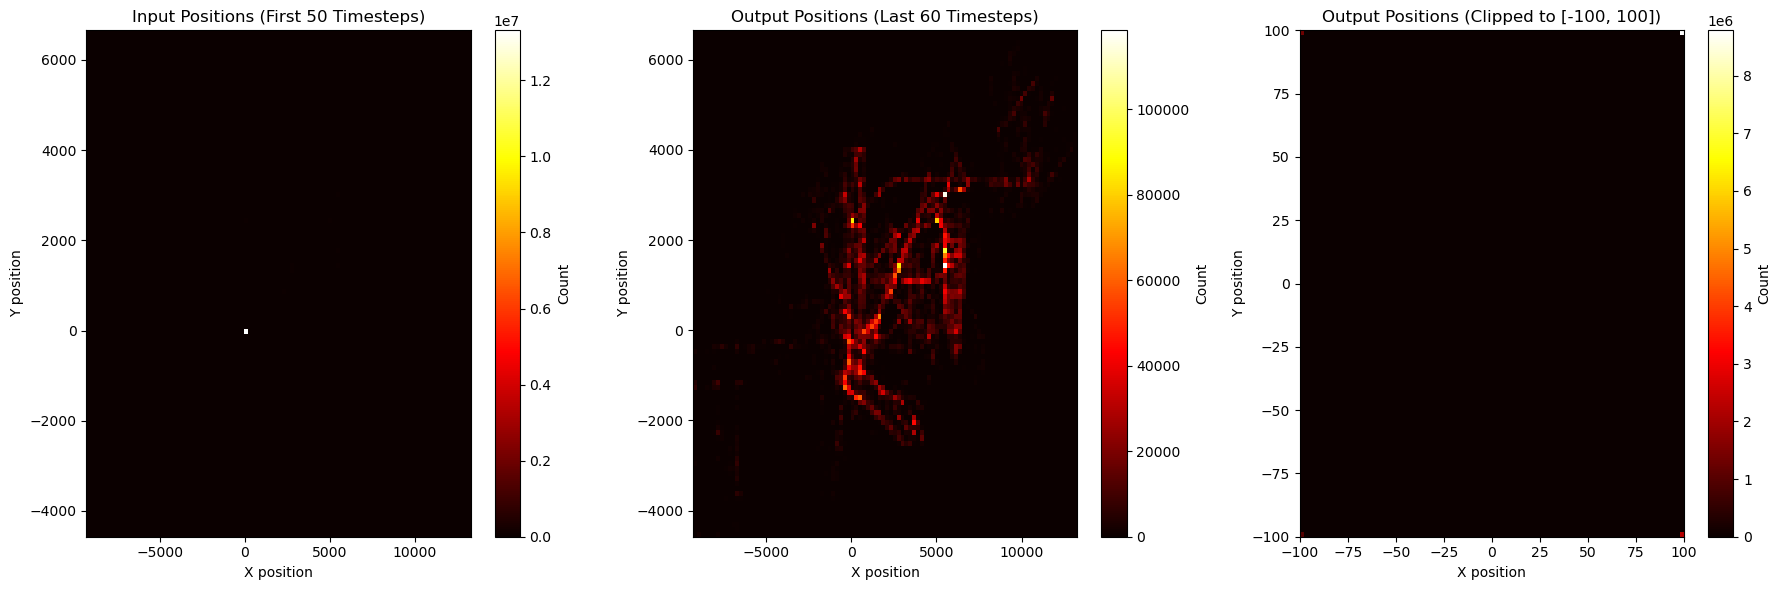

In [5]:
input_positions = train_data[:, :, :50, :2].reshape(-1, 2)
output_positions = train_data[:, :, 50:, :2].reshape(-1, 2)

# Filter out padding (agents with all-zero positions)
mask = ~np.all(output_positions == 0, axis=1)
output_positions = output_positions[mask]

x_clipped = np.clip(output_positions[:, 0], -100, 100)
y_clipped = np.clip(output_positions[:, 1], -100, 100)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Input positions heatmap
axs[0].hist2d(input_positions[:, 0], input_positions[:, 1], bins=100, cmap='hot')
axs[0].set_title("Input Positions (First 50 Timesteps)")
axs[0].set_xlabel("X position")
axs[0].set_ylabel("Y position")

# Output positions heatmap
axs[1].hist2d(output_positions[:, 0], output_positions[:, 1], bins=100, cmap='hot')
axs[1].set_title("Output Positions (Last 60 Timesteps)")
axs[1].set_xlabel("X position")
axs[1].set_ylabel("Y position")

# Clipped output heatmap
axs[2].hist2d(x_clipped, y_clipped, bins=100, cmap='hot')
axs[2].set_title("Output Positions (Clipped to [-100, 100])")
axs[2].set_xlabel("X position")
axs[2].set_ylabel("Y position")
for ax in axs:
    plt.colorbar(ax.collections[0], ax=ax, label='Count')

plt.tight_layout()
plt.show()


In [6]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [7]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

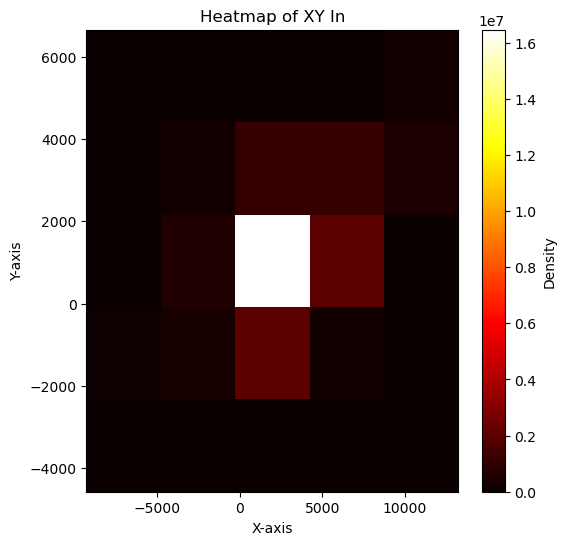

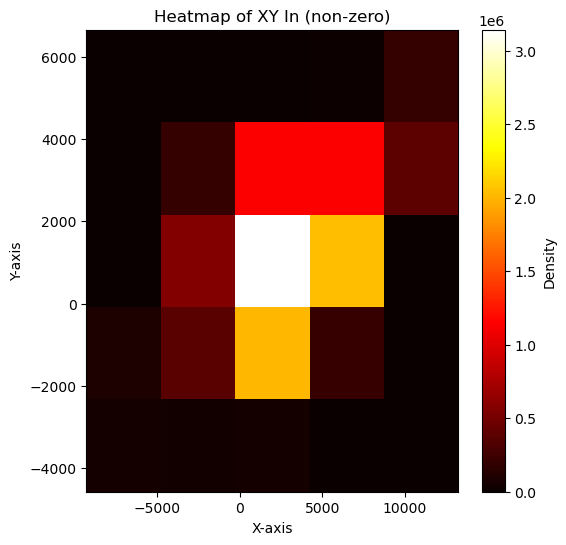

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

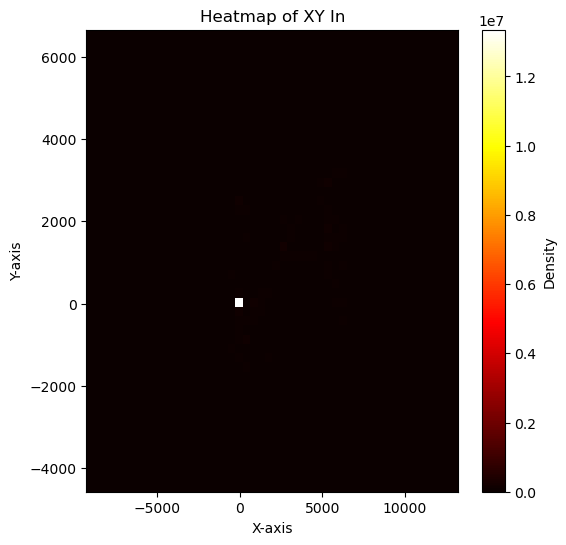

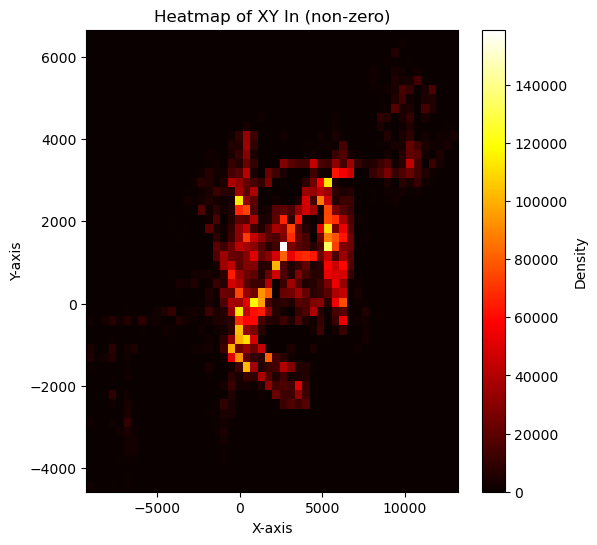

In [9]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

### Heatmap Analysis of Agent Positions

**What we're visualizing:**
- **Left:** Positions of all agents over the first 50 timesteps (input to the model)
- **Middle:** Positions of all agents over the next 60 timesteps (target for prediction)
- **Right:** Clipped output positions within [-100, 100] to focus on dense central activity

**What this tells us:**
- The vast majority of input and output motion occurs in a small, localized area.
- Output positions (future motion) show more spatial spread and structured paths, indicating realistic driving trajectories.
- The zoomed-in view reveals that most predictions stay within a tight cluster, helpful for normalization and bounding model outputs.


# Additional EDA

What agent types appear in the training data? How do their features (position, velocity, heading, etc.) differ?

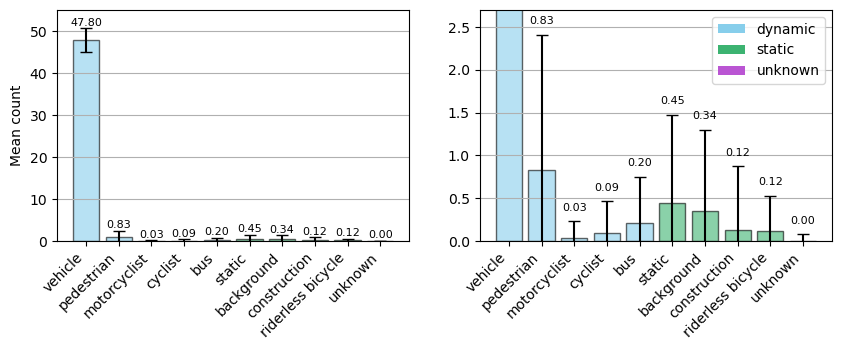

In [6]:
# Mean object type counts

agent_types = train_data[:, :, 0, 5]
agent_types = agent_types.astype(int)

counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=10), axis=1, arr=agent_types)

avg_dist = counts.mean(axis=0)
std_dist = counts.std(axis=0)
time = np.arange(len(avg_dist))

object_types = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless bicycle', 'unknown']
colors = ['skyblue' for x in range(5)] + ['mediumseagreen' for x in range(4)] + ['mediumorchid']

# print("Average distribution of digits 0–9:")
# for digit, avg_count, std_count in zip(time, avg_dist, std_dist):
#     print(f"{digit}: {avg_count:.2f}, {std_count:.2f}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
plot_num = 0
for ax in axes:
    bars = ax.bar(time, avg_dist, yerr=std_dist, alpha=0.6, edgecolor='black', capsize=4, color=colors)
    ax.set_xticks(np.arange(len(object_types)), object_types, rotation=45, ha='right')
    ax.grid(axis='y')

    for i, (mean, std) in enumerate(zip(avg_dist, std_dist)):
        y = mean + std + 0.1  # position just above the error bar
        if plot_num == 1 and y > 2.7:  # skip if label would go outside the clipped axis
            continue
        ax.text(i, y, f'{mean:.2f}', ha='center', va='bottom', fontsize=8)

    if plot_num == 0:
        ax.set_ylabel('Mean count')
        ax.set_ylim([0, 55])
    elif plot_num == 1:
        ax.set_ylim([0, 2.7])
        legend_elements = [
            Patch(facecolor='skyblue', label='dynamic'),
            Patch(facecolor='mediumseagreen', label='static'),
            Patch(facecolor='mediumorchid', label='unknown'),
        ]
        ax.legend(handles=legend_elements)
    plot_num += 1

# Caption: Mean of agent types across scenes, with standard deviations shown as error bars.
# Right plot has clipped y-axis to better display non-vehicular mean counts.
fig.savefig('mean_agent_types.png', dpi=300, bbox_inches='tight')

How does zero-padding in trajectory data affect the number of active agents in scenes?

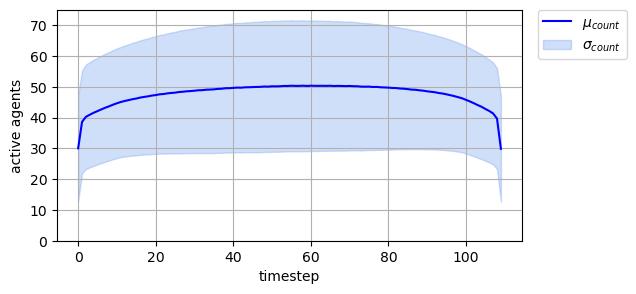

In [7]:
nonzero_pos = np.count_nonzero(train_data[:, :, :, :2] != 0, axis=3)
agents_nonzero = np.sum(nonzero_pos, axis=1)

mean_counts = np.mean(agents_nonzero, axis=0)
std_counts = np.std(agents_nonzero, axis=0)
timesteps = np.arange(len(std_counts))

plt.figure(figsize=(6, 3))
plt.plot(timesteps, mean_counts, label='$\mu_{count}$', color='blue')
plt.fill_between(timesteps, mean_counts - std_counts, mean_counts + std_counts,
                 alpha=0.3, label='$\sigma_{count}$', color='cornflowerblue')

plt.xlabel('timestep')
plt.ylabel('active agents')
plt.ylim([0, 75])

plt.legend(loc='upper right', bbox_to_anchor=(1.24, 1.03))
plt.grid(True)

plt.savefig('active_agents.png', dpi=300, bbox_inches='tight')

What's the average agent speed over timesteps for each agent?

In [8]:
object_types = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']

avg_speeds = np.zeros((110, len(object_types)))
std_speeds = np.zeros((110, len(object_types)))

for i in range(len(object_types)):
    object_data_mask = train_data[:, :, :, 5] == i  # i indexes into object type
    object_data = np.where(object_data_mask[..., np.newaxis], train_data, np.nan)

    object_velocity_x = object_data[:, :, :, 2]
    object_velocity_y = object_data[:, :, :, 3]

    object_speed = np.sqrt(object_velocity_x**2 + object_velocity_y**2)
    avg_speeds[:, i] = np.nanmean(object_speed, axis=(0, 1))
    std_speeds[:, i] = np.nanstd(object_speed, axis=(0, 1))

np.save('object_avg_speeds.npy', avg_speeds)
np.save('object_std_speeds.npy', std_speeds)

avg_speeds = np.load('object_avg_speeds.npy')
std_speeds = np.load('object_std_speeds.npy')

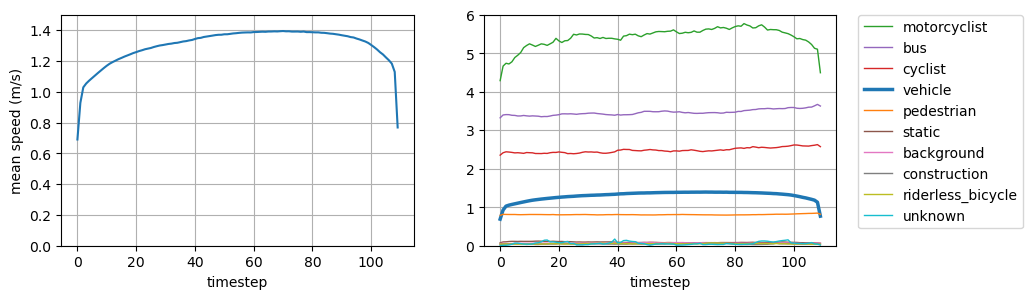

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
t = np.arange(110)

# First plot: focus on vehicle speeds
ax[0].plot(t, avg_speeds[:, 0])

ax[0].set_xlabel('timestep')
ax[0].set_ylabel('mean speed (m/s)')
ax[0].set_ylim([0, 1.5])
ax[0].grid()

# Second plot: all objects shown
for i in range(len(object_types)):
    if i == 0:
        linewidth = 2.5
    else:
        linewidth = 1
    object_type = object_types[i]
    ax[1].plot(t, avg_speeds[:, i], label=object_type, linewidth=linewidth)

ax[1].set_xlabel('timestep')
# ax[1].set_ylabel('mean speed (m/s)')
ax[1].set_ylim([0, 6])
ax[1].grid()

handles, labels = plt.gca().get_legend_handles_labels()
ordered_labels = ['motorcyclist', 'bus', 'cyclist', 'vehicle', 'pedestrian', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']
ordered_handles = [handles[labels.index(lbl)] for lbl in ordered_labels]
ax[1].legend(ordered_handles, ordered_labels, loc='upper right', bbox_to_anchor=(1.55, 1.03))

fig.savefig('avg_object_speeds.png', dpi=300, bbox_inches='tight')

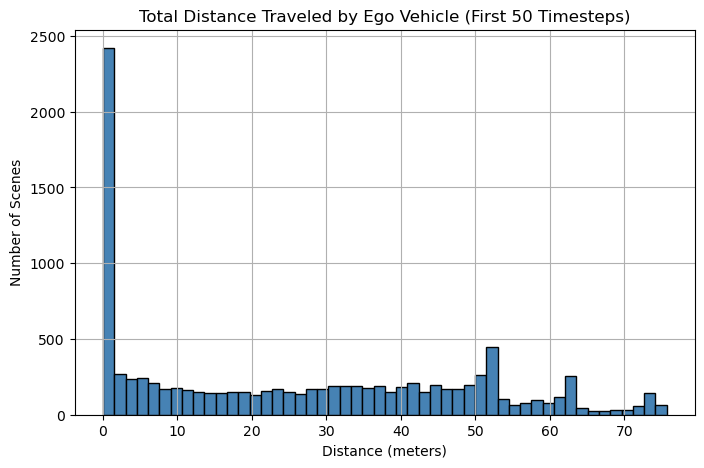

In [25]:
ego_xy = train_data[:, 0, :50, :2]

distances = np.sqrt(np.sum(np.diff(ego_xy, axis=1)**2, axis=2))
scene_distances = distances.sum(axis=1)
plt.figure(figsize=(8, 5))
plt.hist(scene_distances, bins=50, color='steelblue', edgecolor='black')
plt.title("Total Distance Traveled by Ego Vehicle (First 50 Timesteps)")
plt.xlabel("Distance (meters)")
plt.ylabel("Number of Scenes")
plt.grid(True)
plt.show()


### Ego Vehicle Motion Analysis

This visualization shows the total distance traveled by the ego vehicle (agent 0) in each training scene over the first 50 timesteps — which is the full input window the model receives.

**What we’re visualizing:**
- A histogram of per-scene movement magnitude for the ego agent.
- Calculated using the cumulative (x, y) distance over 50 time steps.

**What this tells us:**
- How dynamic the ego vehicle typically is.
- Whether most ego vehicles move straight, stop, or stay still.
- Helps identify whether the dataset is biased toward stationary agents or includes a wide range of driving behaviors.


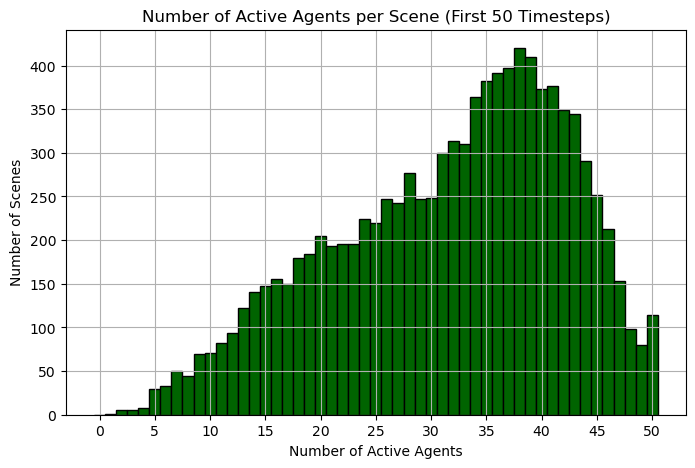

In [26]:
agent_activity = np.any(train_data[:, :, :50, :2] != 0, axis=2)
active_counts = np.sum(np.any(agent_activity, axis=2), axis=1)

plt.figure(figsize=(8, 5))
plt.hist(active_counts, bins=range(0, 52), color='darkgreen', edgecolor='black', align='left')
plt.title("Number of Active Agents per Scene (First 50 Timesteps)")
plt.xlabel("Number of Active Agents")
plt.ylabel("Number of Scenes")
plt.grid(True)
plt.xticks(range(0, 51, 5))
plt.show()


### Agent Count per Scene (Activity Analysis)

This plot shows how many agents are actually active (i.e., non-zero motion) in each scene during the first 50 timesteps — the input window for the model.

**What we’re visualizing:**
- A histogram of the number of active (non-zero) agents per scene.
- Useful for identifying how dense or sparse scenes are.

**What this tells us:**
- Many scenes don’t have all 50 agents moving — several are zero-padded.
- Crowded scenes may influence the ego differently than sparse ones.
- Helps decide if modeling interactions between agents is important.


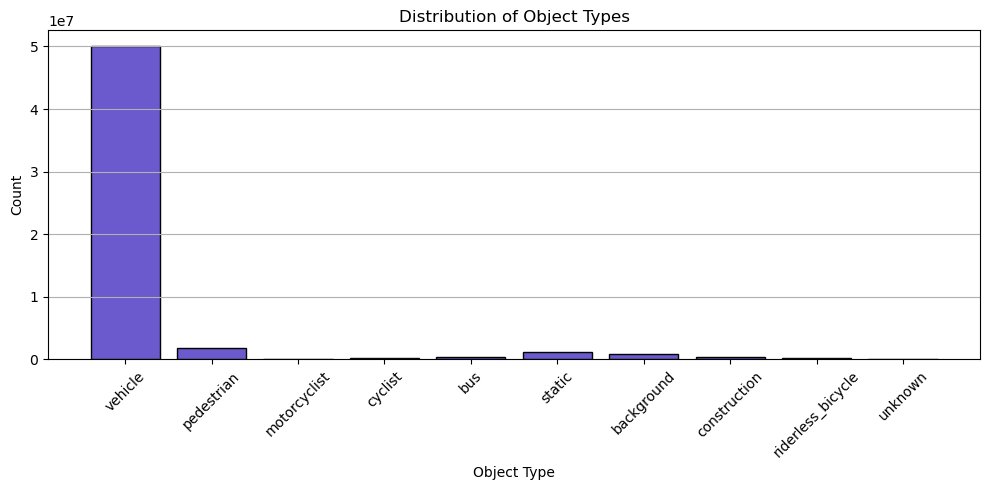

In [28]:
object_types = train_data[:, :, :, 5].astype(int).flatten()

type_names = [
    'vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus',
    'static', 'background', 'construction', 'riderless_bicycle', 'unknown'
]

type_counts = [np.sum(object_types == i) for i in range(len(type_names))]

plt.figure(figsize=(10, 5))
plt.bar(type_names, type_counts, color='slateblue', edgecolor='black')
plt.xticks(rotation=45)
plt.title("Distribution of Object Types")
plt.xlabel("Object Type")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Object Type Distribution

This chart shows the frequency of each agent type across all scenes and timesteps. Every agent has an `object_type` label indicating what kind of entity it is (e.g., vehicle, pedestrian, static object).

**What we’re visualizing:**
- The total count of each object type across the training dataset.

**What this tells us:**
- The dataset is likely dominated by vehicles, but includes other classes too.
- Helps assess whether modeling strategies should account for different behaviors by type.
- Reveals how much of the data is potentially irrelevant (e.g., background or static).
